In [1]:
%load_ext autoreload
%autoreload 2

# 2D Transformations

![alt text](../images/ch_2_4_transforms_2d.png "Logo Title Text 1")

In [ ]:
import sys
import os
__src_dir__ = os.path.abspath('../src')
assert os.path.exists(__src_dir__), "'src' dir not found: " + __src_dir__
if __src_dir__ not in sys.path:
    sys.path.append(__src_dir__)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import uniform as rand_rng

In [4]:
from mvg.synth_data_gen import (
        make_4sq_img, 
        plot_rect_pts, 
        transform_rect_pts,
)

from mvg.transforms_2d import MakeTf2d, RandTf2d

def apply_transform_and_plot(M):
    img, rect_pts, edges = make_4sq_img(scale_by=2)
    img_ = cv2.warpPerspective(img, M, (500, 500))
    rect_pts_ = transform_rect_pts(M, rect_pts)
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[1].imshow(img_)
    plot_rect_pts(ax[0], rect_pts, edges, markersize=10, markeredgewidth=2)
    plot_rect_pts(ax[1], rect_pts_, edges, markersize=10, markeredgewidth=2)
    return img, rect_pts, edges, img_, rect_pts_

# Euclidean Transform
---
![alt text](../images/ch_2_4_transforms_2d_euclidean.png "Logo Title Text 1")

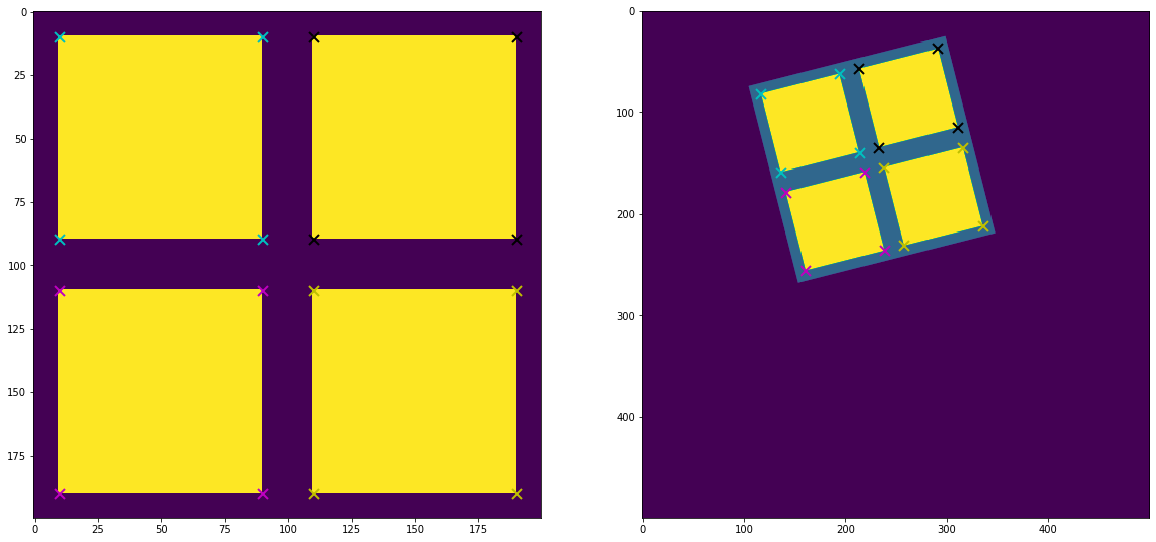

In [5]:
M = RandTf2d.similarity(
        rot_rng=(-0.9, 0.1),
        t_x_rng=(10, 100), 
        t_y_rng=(10, 100),
        scale_rng=(1, 1),  ## <--- same as similarity but no scale
)

img, rect_pts, edges, img_, rect_pts_ = apply_transform_and_plot(M)

<br><br><br><br>

# Similarity Transform
---

![alt text](../images/ch_2_4_transforms_2d_similarity.png "Logo Title Text 1")

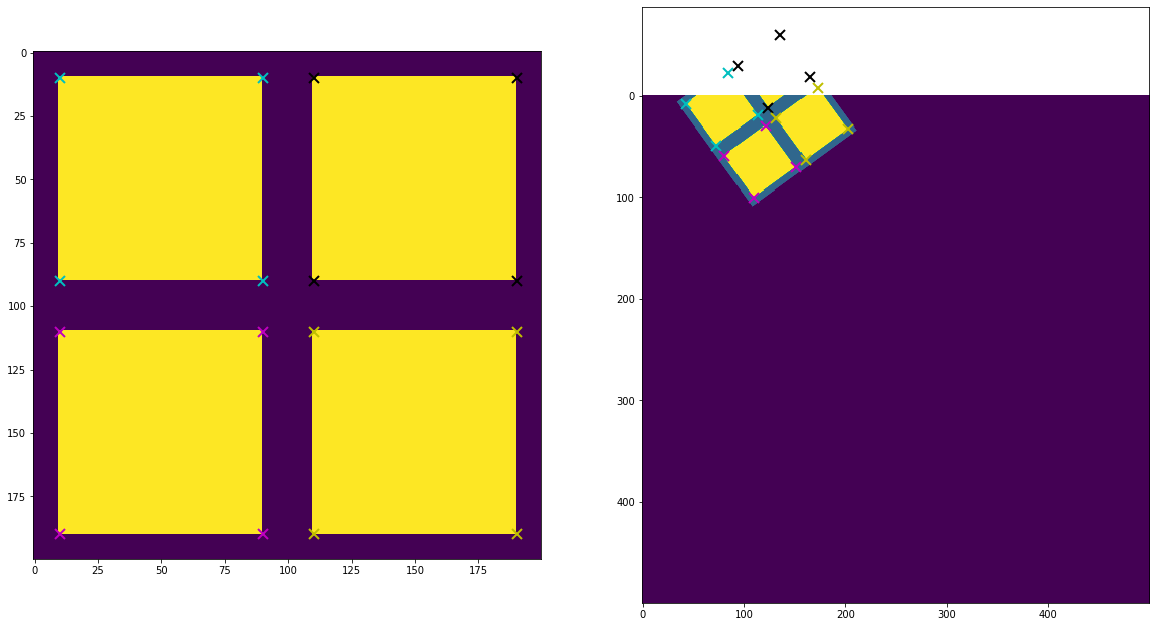

In [6]:
M = RandTf2d.similarity(
        rot_rng=(-0.9, 0.1),
        t_x_rng=(10, 100), 
        t_y_rng=(10, 100),
        scale_rng=(0.5, 1.5),
)

img, rect_pts, edges, img_, rect_pts_ = apply_transform_and_plot(M)

<br><br><br><br>

# Affine Transform
---
![alt text](../images/ch_2_4_transforms_2d_affine.png "Logo Title Text 1")
<br><br><br>
![alt text](../images/ch_2_4_3_affine.png "Logo Title Text 1")

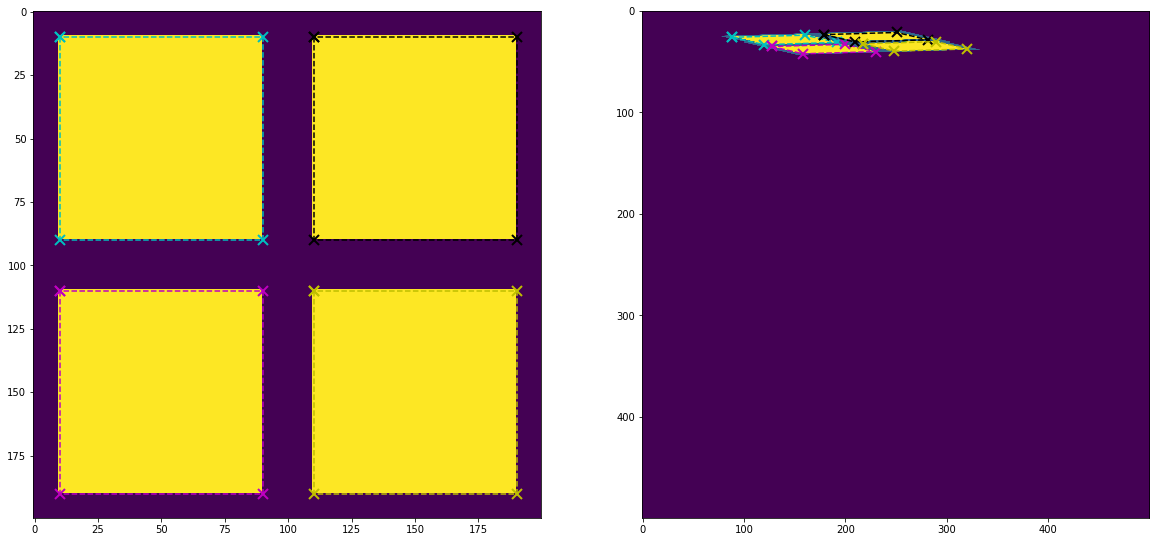

In [133]:
M = RandTf2d.affine(
        theta_rng=(-0.9, 0.1),
        phi_rng=(-0.9, 0.1),
        scale_x_rng=(0.9, 1.1),
        scale_y_rng=(0., 1.1), 
        t_x_rng=(10, 100), 
        t_y_rng=(10, 100),
)

img, rect_pts, edges, img_, rect_pts_ = apply_transform_and_plot(M)

<br><br><br><br>

# Projective Transform
---

![alt text](../images/ch_2_4_projective.png "Logo Title Text 1")

Projective Transform is similar to **Affine Transform** except it has the additional parameter $\mathbf{v^T}$.
<br><br>
_Affine Transform:_
<center>
$
\mathbf{x'} = \mathbf{H}_p\mathbf{x} =  \begin{bmatrix}
  \mathbf{A}_{2\times2} & \mathbf{t} \\
  \mathbf{0}^T & 1
 \end{bmatrix}_{3\times3} \mathbf{x}
$
</center>

_Projective Transform (Notice the differences <u>**underscored**</u>):_ 

<center>
$
\mathbf{x'} = \mathbf{H}_p\mathbf{x} =  \begin{bmatrix}
  \mathbf{A}_{2\times2} & \mathbf{t} \\
  \underline{\mathbf{v^T}} & \underline{v}
 \end{bmatrix}_{3\times3} \mathbf{x}
$
</center>


matrix([[ -0.427245,  -0.516691, 892.792453],
        [  0.312508,  -0.214305, 209.988275],
        [ -0.000341,   0.000091,   1.      ]])

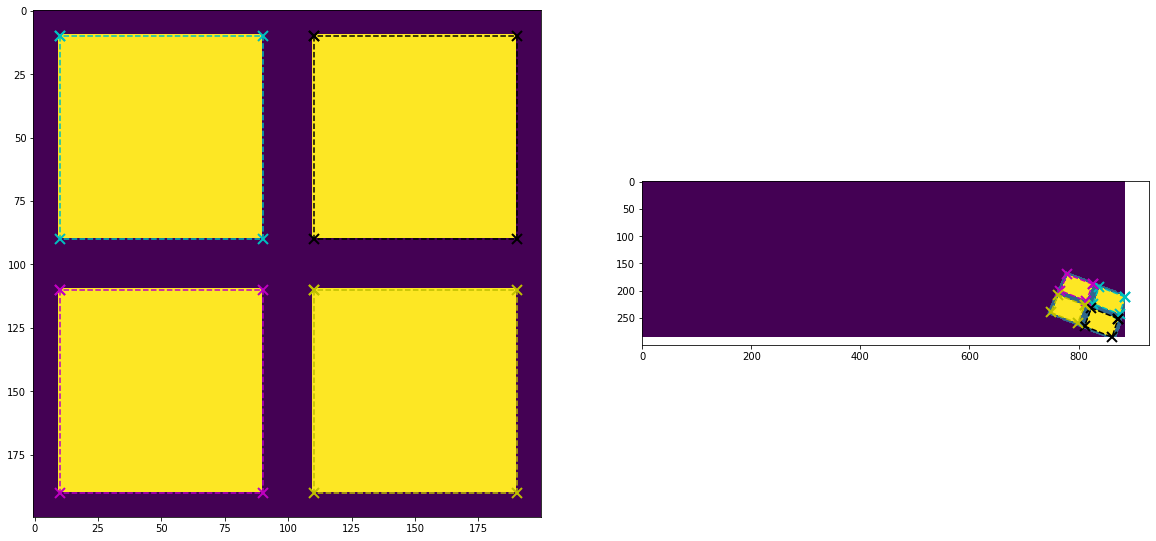

In [153]:
## Randomly picking Values
M = MakeTf2d.projective(
        theta=rand_rng(-0.1, 0.1),
        phi=rand_rng(-0.1, 0.1),
        scale_x=rand_rng(0., 1.),
        scale_y=rand_rng(0., 1.), 
        t_x=rand_rng(-50, 50), 
        t_y=rand_rng(-50, 50),
        v_x=rand_rng(-0.001, 0.001),
        v_y=rand_rng(-0.001, 0.001),
)


## Composing Projective Transform from Parts
H_e = MakeTf2d.similarity(
        theta=rand_rng(-0.5, 0.5),
        t_x=rand_rng(-50, 50), 
        t_y=rand_rng(-50, 50),
)
sx, sy = rand_rng(0., 1.), rand_rng(0., 1.)
H_a = np.matrix([
    [1., sy, 0.],
    [sx, 1., 0.],
    [0., 0., 1.],
])

p1, p2 = rand_rng(-0.001, 0.001), rand_rng(-0.001, 0.001)
H_p = np.matrix([
    [1., 0., 0.],
    [0., 1., 0.],
    [p1, p2, 1 ],
])
M = H_e * H_a * H_p

## A Known projective geometry transform
M = np.matrix([
    [ -0.427245,  -0.516691, 892.792453],
    [  0.312508,  -0.214305, 209.988275],
    [ -0.000341,   0.000091,   1.      ],
])

def mult_img_pts(H, pts):
    if pts.shape[1] == 2:
        pts = cv2.convertPointsToHomogeneous(pts).reshape(len(pts), 3)
    w_pts = np.array(np.matmul(H, pts.transpose()).transpose())
    return np.array([[x/z, y/z, 1] for x, y, z in w_pts])

img, rect_pts, edges = make_4sq_img(scale_by=2)
rect_pts[:, -1] = 1
rect_pts_ = mult_img_pts(M, rect_pts)
w = int(max(img.shape[1], max(rect_pts_[:, 0])))
h = int(max(img.shape[0], max(rect_pts_[:, 1])))
img_ = cv2.warpPerspective(img, M, (w, h))
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img)
ax[1].imshow(img_)
plot_rect_pts(ax[0], rect_pts, edges, markersize=10, markeredgewidth=2)
plot_rect_pts(ax[1], rect_pts_, edges, markersize=10, markeredgewidth=2)

M
